In [1]:
import numpy as np
import pandas as pd
from torch.nn import LSTM, Linear
from torch.optim import Adam
import torch
import torch.nn as nn

In [2]:
# 读取数据，数据为’珠江啤酒’从开市到2020年10月16日的交易数据
stock = pd.read_csv('002461.csv', encoding='gb18030')
stock.head()

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2020-10-16,'002461,珠江啤酒,9.78,10.12,9.73,10.03,9.99,-0.21,-2.1021,0.3461,7660015,7.548379e+07,2.164635e+10,2.164635e+10
1,2020-10-15,'002461,珠江啤酒,9.99,10.10,9.89,10.10,10.04,-0.05,-0.498,0.3088,6834160,6.825145e+07,2.211115e+10,2.211115e+10
2,2020-10-14,'002461,珠江啤酒,10.04,10.43,10.01,10.32,10.33,-0.29,-2.8074,0.4001,8854900,8.966025e+07,2.222182e+10,2.222182e+10
3,2020-10-13,'002461,珠江啤酒,10.33,10.37,10.12,10.23,10.23,0.1,0.9775,0.3573,7908392,8.132436e+07,2.286368e+10,2.286368e+10
4,2020-10-12,'002461,珠江啤酒,10.23,10.24,9.92,9.98,9.98,0.25,2.505,0.4554,10080572,1.021345e+08,2.264235e+10,2.264235e+10


In [3]:
stock.shape

(2468, 15)

In [4]:
# 先将日期转换成datetime形式，并设置为index
stock['日期'] = pd.to_datetime(stock['日期'])
stock.set_index(stock['日期'], drop=True, inplace=True)

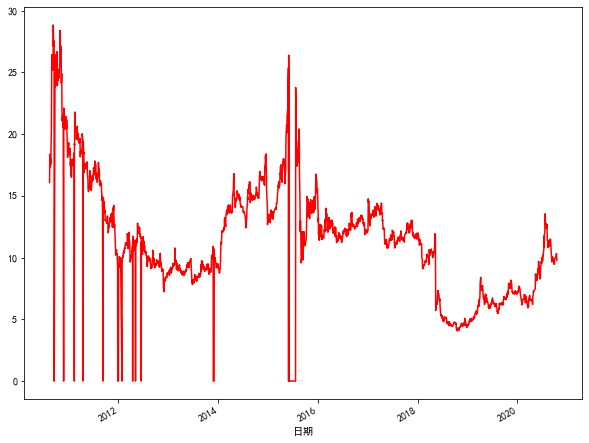

In [5]:
# 绘制收盘价格曲线
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10,8)
stock['收盘价'].plot(c='r')
plt.show()

In [6]:
# 制作lstm输入数据
timesteps_in = 1
timesteps_out = 1

df = stock[['收盘价']].interpolate()     

# 特征数
n_var = df.shape[1]


cols=[]
names=[]
# 历史数据
for i in range(timesteps_in,0,-1):
    cols.append(df.shift(-i))               # 由于下载的数据在时间维度是降序，因此往上移动
    names+=['var%d(t-%d)'%(j+1,i) for j in range(n_var)]
# 预测数据
for i in range(timesteps_out):
    cols.append(df.shift(i))               # 由于下载的数据在时间维度是降序，因此往下移动
    if i == 0:
        names += ['var%d(t)'%(j+1) for j in range(n_var)]
    else:
        names += ['var%d(t+%d)'%(j+1, i) for j in range(n_var)]
        
data = pd.concat(cols, axis=1)
data.columns = names
data.dropna(inplace=True)
data.head()

,var1(t-1),var1(t)
日期,,
2020-10-16,9.99,9.78
2020-10-15,10.04,9.99
2020-10-14,10.33,10.04
2020-10-13,10.23,10.33
2020-10-12,9.98,10.23


In [7]:
data = np.array(data.values.astype('float32'))
# 由于下载的数据是降序，因此要翻转一下
data = data[::-1,:]
data.shape

(2467, 2)

In [8]:
# 训练数据与预测数据
train_x = data[:,0]
train_y = data[:,1]

# lstm的输入维度 (batch_size,seq_len,feature_size)
train_x = train_x.reshape((data.shape[0],1,1))
train_y = train_y.reshape((data.shape[0],1,1))
print(train_x.shape, train_y.shape)

# 设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 数据类型转换
x = torch.from_numpy(train_x.copy()).type(torch.FloatTensor).to(device)
y = torch.from_numpy(train_y.copy()).type(torch.FloatTensor).to(device)

(2467, 1, 1) (2467, 1, 1)


In [9]:
# 模型搭建 lstm + linear
class stock_predictor(nn.Module):
    def __init__(self, n_var, hidden, timesteps_out):
        super(stock_predictor,self).__init__()
        
        self.lstm = nn.LSTM(input_size=n_var,        # 特征维度
                       hidden_size=hidden,      # 隐含层有几个神经元
                       num_layers=2,            # lstm的层数
                       bias=True,               # 偏置
                       batch_first=True,        # (batch,seq,feature)
                       dropout=0.8,             # dropout的概率
                       bidirectional=False)     # 是否是双向LSTM
        self.fc = nn.Linear(in_features=hidden,
                       out_features=timesteps_out)
    def forward(self, x):
        fea, (_,_)= self.lstm(x)
        output = self.fc(fea)
        return output

In [10]:
# 模型定义
model=stock_predictor(n_var=1, hidden=128, timesteps_out=1)
model.to(device)

# 训练设置
Epoch=5000
learning_rate = 1e-3
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
loss_curse=[]
for epoch in range(Epoch):
    # 前向传播
    out=model(x)
    # 计算loss
    loss = criterion(out, y)
    loss_curse.append(loss.item())
    # 梯度清零
    optimizer.zero_grad()
    # 反向传播
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch:%d, loss:%.4f' % (epoch, loss.item()))

epoch:0, loss:10.8219
epoch:100, loss:2.1791
epoch:200, loss:1.1624
epoch:300, loss:0.9211
epoch:400, loss:0.7452
epoch:500, loss:0.6232
epoch:600, loss:0.5377
epoch:700, loss:0.4859
epoch:800, loss:0.4565
epoch:900, loss:0.4225
epoch:1000, loss:0.4325
epoch:1100, loss:0.4456
epoch:1200, loss:0.4161
epoch:1300, loss:0.4292
epoch:1400, loss:0.4053
epoch:1500, loss:0.4154
epoch:1600, loss:0.4191
epoch:1700, loss:0.3998
epoch:1800, loss:0.4010
epoch:1900, loss:0.4077
epoch:2000, loss:0.4061
epoch:2100, loss:0.3983
epoch:2200, loss:0.4114
epoch:2300, loss:0.4044
epoch:2400, loss:0.3855
epoch:2500, loss:0.3957
epoch:2600, loss:0.3901
epoch:2700, loss:0.3922
epoch:2800, loss:0.3858
epoch:2900, loss:0.3907
epoch:3000, loss:0.3779
epoch:3100, loss:0.3907
epoch:3200, loss:0.3620
epoch:3300, loss:0.3742
epoch:3400, loss:0.3745
epoch:3500, loss:0.3716
epoch:3600, loss:0.3703
epoch:3700, loss:0.3584
epoch:3800, loss:0.3494
epoch:3900, loss:0.3641
epoch:4000, loss:0.3574
epoch:4100, loss:0.3664
epo

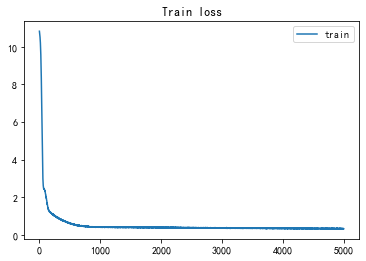

In [12]:
# 绘制训练损失曲线
plt.rcParams['figure.figsize']=(6,4)
pd.DataFrame(loss_curse, columns=['train']).plot()
plt.title('Train loss')
plt.show()

In [13]:
# 预测现有的值
pred=model(x)
plot_data = [x.cpu().detach().numpy().reshape(x.shape[0]), 
             pred.cpu().detach().numpy().reshape(x.shape[0])]

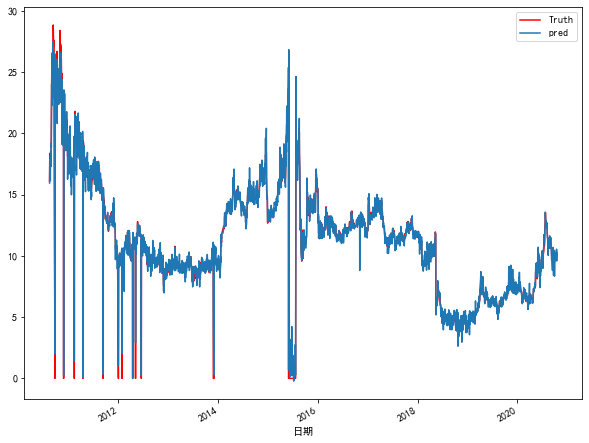

In [14]:
plt.rcParams['figure.figsize']=(10,8)
df = pd.DataFrame(plot_data).T
df.columns=('Truth','pred')
df.index = stock['日期'][::-1][1:]
df['Truth'].plot(c='r')
df['pred'].plot()
plt.legend()
plt.show()

In [15]:
from datetime import timedelta, datetime

# str
start_time = '2020-10-17'
stop_time = '2021-10-17'

# str转换成time
pred_time = datetime.strptime(start_time, '%Y-%m-%d')
stop_time = datetime.strptime(stop_time, '%Y-%m-%d')

delta = timedelta(days=1)

# 预测未来3个月
# 初始值
ini = df.loc['2020-10-16']['Truth'].astype('float32')

model.to('cpu')

pred_time_list=[]
pred_future = []

while pred_time <= stop_time:
    
    # 直到stop_time
    # 如果pred_time为周末则continue, 从0开始，5，6分别为周六日
    if (pred_time.weekday() == 5) or (pred_time.weekday() == 6):
        pred_time = pred_time + delta
        continue
    
    # 将time转换成str
    #pred_time_str = datetime.strftime(pred_time, '%Y-%m-%d')
    
    # 将值转换成Tensor
    ini = torch.from_numpy(ini.reshape(1,1,1))  # 转成tensor
    ini = torch.FloatTensor(ini)
    
    # 预测
    ini = model(ini).detach().numpy().reshape(1)
    
    # 记录时间与预测值
    pred_time_list.append(pred_time)
    pred_future.append(ini.astype('float32').item())  # 转成numpy 
    
    # time + 1
    pred_time = pred_time + delta

In [16]:
pred_3mouths = pd.DataFrame({'time':pred_time_list, 'future_pred':pred_future}).set_index('time')

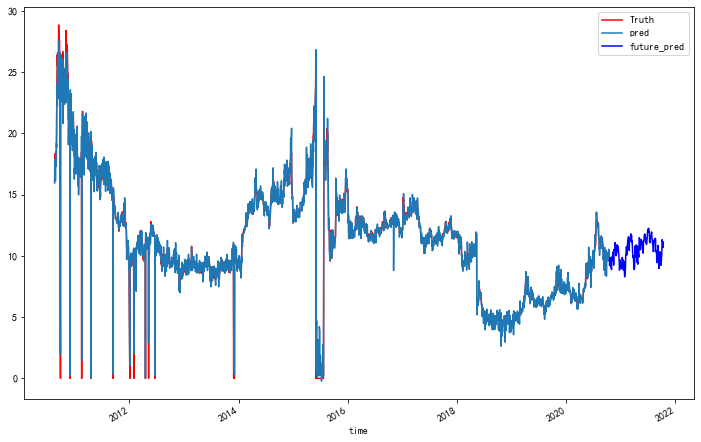

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax = df['Truth'].plot(ax=ax,c='r')      
df['pred'].plot(ax=ax)  
pred_3mouths.plot(ax=ax,c='b')
plt.legend()
plt.show()